In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [5]:
df = load_pkl('./data/feat_engin/lgbm/data_15min_1hour_1day.pkl')

In [6]:
df.shape

(2362117, 1712)

In [7]:
df.head()

,time,close,volume,ticker,tmos_close,index_1hour,index_1day,result,delta_time,income_rate,...,tmos_close_1day_w10_min/tmos_close_1day_w10_max,close_1day_w20_min/close_1day_w20_max,volume_1day_w20_min/volume_1day_w20_max,tmos_close_1day_w20_min/tmos_close_1day_w20_max,close_1day_w30_min/close_1day_w30_max,tmos_close_1day_w30_min/tmos_close_1day_w30_max,close_1day_w60_min/close_1day_w60_max,tmos_close_1day_w60_min/tmos_close_1day_w60_max,close_1day_w120_min/close_1day_w120_max,tmos_close_1day_w120_min/tmos_close_1day_w120_max
0,2022-05-04 10:00:00,31.520000,165423.0,AFLT,4.30,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-04 10:15:00,31.920000,99825.0,AFLT,4.32,NaN,NaN,LOSE,0 days 00:15:00,0.994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-04 10:30:00,32.400002,171391.0,AFLT,4.29,NaN,NaN,WIN,0 days 00:45:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-04 10:45:00,32.099998,66741.0,AFLT,4.27,0.0,NaN,WIN,0 days 00:30:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-04 11:00:00,31.940001,42552.0,AFLT,4.25,0.0,NaN,WIN,0 days 00:15:00,1.014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df['result'].value_counts(normalize=True)

result
DNF     0.487526
LOSE    0.407979
WIN     0.104495
Name: proportion, dtype: float64

In [9]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.994000
0.01    0.994000
0.10    0.994000
0.20    0.994000
0.30    0.994000
0.40    0.994000
0.50    0.997773
0.60    0.999747
0.70    1.001901
0.80    1.005115
0.90    1.014000
0.99    1.014000
1.00    1.014000
Name: income_rate, dtype: float64

In [10]:
#распределение времени в часах
(df['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       4.0
0.50       4.0
0.60       4.0
0.70       4.0
0.80      13.0
0.90      16.0
0.99      65.0
1.00    6734.0
Name: delta_time, dtype: float64

## CHANGE TARGET

In [13]:
def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: #short game
        mask_val_first = np.array(df['close'] > val_first)
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        if val_first < val_second:
            income_rate = res_price/start_price
        else: #short game
            income_rate = (2*start_price-res_price)/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            if val_first < val_second:
                income_rate = res_price/start_price
            else: #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            if val_first < val_second:
                income_rate = res_price/start_price
            else:  #short game
                income_rate = (2*start_price-res_price)/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })

    #макс выигрыш и потери
    if percent_first < percent_second:  
        df_result["income_rate"] = np.maximum(df_result["income_rate"], percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], percent_second) #макс выигрыш
    else:
        df_result["income_rate"] = np.maximum(df_result["income_rate"], 2-percent_first) #макс потери
        df_result["income_rate"] = np.minimum(df_result["income_rate"], 2-percent_second) #макс выигрыш
    
    df_result['income_rate'] -= 0.001
    
    return df_result    

In [14]:
inds = np.arange(df.shape[0])
inds.shape

(2362117,)

In [23]:
df_result = get_df_target(df[['time', 'close', 'ticker']], inds, percent_first=1.005, percent_second=0.985, points_to_wait=4*2*1)

python(54745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|█████████████████████████████████████████████████████████████| 2362117/2362117 [09:18<00:00, 4226.70it/s]


In [29]:
dump_pkl(df_result, './data/feat_engin/lgbm/df_result_+0.5_-1.5_2hour.pkl')

In [31]:
df_result = load_pkl('./data/feat_engin/lgbm/df_result_+0.5_-1.5_2hour.pkl')
df_result

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,LOSE,AFLT,0 days 00:15:00,0.994000,31.920000,1
1,1,2022-05-04 10:15:00,31.920000,LOSE,AFLT,0 days 00:15:00,0.994000,32.400002,2
2,2,2022-05-04 10:30:00,32.400002,WIN,AFLT,0 days 00:45:00,1.014000,31.299999,5
3,3,2022-05-04 10:45:00,32.099998,WIN,AFLT,0 days 00:30:00,1.014000,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,WIN,AFLT,0 days 00:15:00,1.014000,31.299999,5
...,...,...,...,...,...,...,...,...,...
2362112,2362112,2025-02-17 22:45:00,396.179993,DNF,BSPB,0 days 01:00:00,0.995517,397.559998,2362116
2362113,2362113,2025-02-17 23:00:00,397.089996,DNF,BSPB,0 days 00:45:00,0.997816,397.559998,2362116
2362114,2362114,2025-02-17 23:15:00,397.519989,DNF,BSPB,0 days 00:30:00,0.998899,397.559998,2362116
2362115,2362115,2025-02-17 23:30:00,396.480011,DNF,BSPB,0 days 00:15:00,0.996276,397.559998,2362116


In [34]:
df_result['result'].value_counts(normalize=True)


result
DNF     0.668538
LOSE    0.277442
WIN     0.054020
Name: proportion, dtype: float64

In [36]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.994000
0.01    0.994000
0.10    0.994000
0.20    0.994000
0.30    0.995189
0.40    0.997438
0.50    0.998737
0.60    0.999819
0.70    1.001204
0.80    1.003272
0.90    1.007475
0.99    1.014000
1.00    1.014000
Name: income_rate, dtype: float64

In [38]:
#распределение времени в часах
(df_result['delta_time']//pd.Timedelta('1 hour')).quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00       0.0
0.01       0.0
0.10       0.0
0.20       1.0
0.30       2.0
0.40       2.0
0.50       2.0
0.60       2.0
0.70       2.0
0.80       2.0
0.90      12.0
0.99      60.0
1.00    6732.0
Name: delta_time, dtype: float64

In [41]:
(df['close'].values == df_result['close'].values).all(), (df['time'].values == df_result['time'].values).all()

(True, True)

In [43]:
df_result.head()

,ind,time,close,result,ticker,delta_time,income_rate,res_price,res_ind
0,0,2022-05-04 10:00:00,31.520000,LOSE,AFLT,0 days 00:15:00,0.994,31.920000,1
1,1,2022-05-04 10:15:00,31.920000,LOSE,AFLT,0 days 00:15:00,0.994,32.400002,2
2,2,2022-05-04 10:30:00,32.400002,WIN,AFLT,0 days 00:45:00,1.014,31.299999,5
3,3,2022-05-04 10:45:00,32.099998,WIN,AFLT,0 days 00:30:00,1.014,31.299999,5
4,4,2022-05-04 11:00:00,31.940001,WIN,AFLT,0 days 00:15:00,1.014,31.299999,5


In [46]:
df[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']] = df_result[['result', 'delta_time', 'income_rate', 'res_price', 'res_ind']]

In [49]:
#проверить данные

mask = df['time'] >= pd.Timestamp('2025-02-01')


i = 3676
cols = ['ticker', 'time', 'close', 'close_1hour', 'close_1day', 'result', 'delta_time', 'income_rate', 'res_price', 'res_ind']
df.loc[mask, cols].iloc[i:i+10]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
250910,FEES,2025-02-03 22:00:00,0.07816,0.07820,0.07898,DNF,0 days 12:00:00,0.999768,0.07810,250918
250911,FEES,2025-02-03 22:15:00,0.07828,0.07820,0.07898,DNF,0 days 12:00:00,0.999511,0.07824,250919
250912,FEES,2025-02-03 22:30:00,0.07830,0.07820,0.07898,DNF,0 days 12:00:00,1.001043,0.07814,250920
250913,FEES,2025-02-03 22:45:00,0.07824,0.07824,0.07898,DNF,0 days 12:00:00,1.001301,0.07806,250921
250914,FEES,2025-02-03 23:00:00,0.07816,0.07824,0.07898,DNF,0 days 12:00:00,1.003350,0.07782,250922
250915,FEES,2025-02-03 23:15:00,0.07812,0.07824,0.07898,DNF,0 days 12:00:00,1.003096,0.07780,250923
250916,FEES,2025-02-03 23:30:00,0.07804,0.07824,0.07898,DNF,0 days 12:00:00,1.001306,0.07786,250924
250917,FEES,2025-02-03 23:45:00,0.07802,0.07802,0.07802,DNF,0 days 12:00:00,1.002076,0.07778,250925
250918,FEES,2025-02-04 10:00:00,0.07810,0.07802,0.07802,DNF,0 days 02:00:00,1.003097,0.07778,250926
250919,FEES,2025-02-04 10:15:00,0.07824,0.07802,0.07802,DNF,0 days 02:00:00,1.004624,0.07780,250927


In [51]:
i = 491081
df[cols].iloc[i:i+1]

,ticker,time,close,close_1hour,close_1day,result,delta_time,income_rate,res_price,res_ind
491081,SGZH,2024-10-18 14:30:00,1.683,1.674,1.682,LOSE,0 days 00:45:00,0.994,1.697,491084


### 1. train/valid/test/test2 split

In [56]:
df['target'] = (df['result'] == 'WIN').astype(int)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_54734/162261981.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target'] = (df['result'] == 'WIN').astype(int)


<Axes: xlabel='time'>

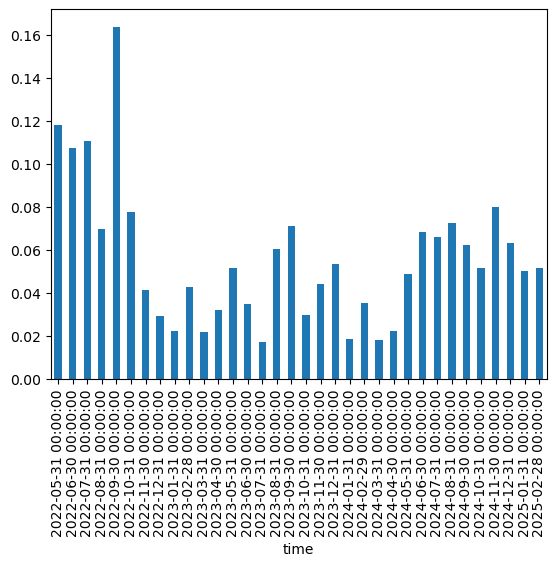

In [58]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

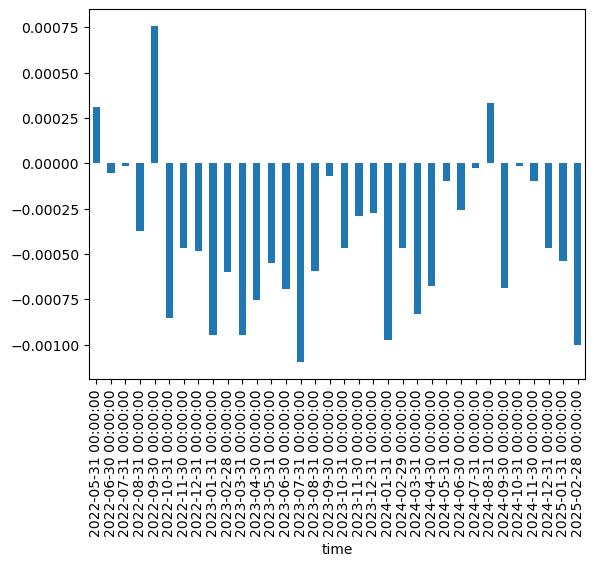

In [59]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [62]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
SBERP    0.017176
SBER     0.018630
LKOH     0.019600
TATNP    0.022390
IRAO     0.023353
MTSS     0.024324
SNGSP    0.025018
GAZP     0.025184
MOEX     0.025726
PHOR     0.026127
TATN     0.026245
ROSN     0.028011
GMKN     0.028288
HYDR     0.029569
TRNFP    0.029871
RTKM     0.029946
SIBN     0.030197
MGNT     0.031738
NVTK     0.032195
ALRS     0.035256
VTBR     0.035859
CHMF     0.036761
MAGN     0.038035
PLZL     0.038106
AFLT     0.038509
SNGS     0.039545
BELU     0.040581
NLMK     0.040968
UPRO     0.041642
RUAL     0.042749
POSI     0.046328
FEES     0.047516
BANEP    0.049035
X5       0.049883
T        0.050020
YDEX     0.051177
BSPB     0.051944
FLOT     0.052811
PIKK     0.053149
AFKS     0.053980
ENPG     0.054348
VSMO     0.056258
SELG     0.060483
MVID     0.062288
SGZH     0.063462
SMLT     0.064340
LSRG     0.067242
VKCO     0.068744
MDMG     0.069193
RASP     0.070202
TRMK     0.071451
NMTP     0.071688
WUSH     0.073319
MTLR     0.073902
FESH     0.081006
RNF

In [65]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
SBERP    0.999162
SBER     0.999168
IRAO     0.999182
LKOH     0.999185
MOEX     0.999209
SNGSP    0.999216
TATN     0.999216
TATNP    0.999217
MTSS     0.999261
ROSN     0.999275
PHOR     0.999315
SIBN     0.999335
CHMF     0.999337
TRNFP    0.999349
RTKM     0.999367
X5       0.999372
PLZL     0.999376
NVTK     0.999395
MGNT     0.999399
ALRS     0.999400
GAZP     0.999425
POSI     0.999431
GMKN     0.999437
BELU     0.999440
YDEX     0.999440
AFLT     0.999441
MAGN     0.999445
HYDR     0.999452
NLMK     0.999459
SNGS     0.999480
AFKS     0.999480
VTBR     0.999492
BANEP    0.999499
BSPB     0.999525
PIKK     0.999538
UPRO     0.999563
RUAL     0.999568
T        0.999577
FEES     0.999604
LSRG     0.999604
FLOT     0.999606
MDMG     0.999608
MVID     0.999683
ENPG     0.999697
SFIN     0.999723
SELG     0.999726
VKCO     0.999751
MTLR     0.999759
SMLT     0.999768
RASP     0.999778
SGZH     0.999791
TRMK     0.999820
NMTP     0.999832
FESH     0.999837
WUSH     0.999843
MTL

In [69]:
df['time'].max()

Timestamp('2025-02-17 23:45:00')

In [71]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2025-01-01')))
mask_test3 = np.array((pd.Timestamp('2025-01-01') <= df['time']))# & (df['time'] < pd.Timestamp('2025-03-01')))

In [73]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1759268, 162196, 161173, 157454)

In [75]:
mask_test3.sum()

122026

In [78]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 122
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all

mask_test3 &= mask_avbl_all


#мб дату неправильно обрезаю

In [79]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1446127, 162196, 161173, 157454)

In [80]:
mask_test3.sum()

122026

In [83]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

1926950

In [84]:
# for col in tqdm(df.columns):
#     assert df.loc[mask_data, col].isnull().sum() == 0, f'Nulls {col}'

In [85]:
df.loc[mask_train, 'ticker'].nunique()

67

In [86]:
#Гуд

In [88]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7504745841874465,
 0.08417239679285918,
 0.0836415060069021,
 0.08171151301279224)

In [90]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.03827879570743095,
 0.06929887296850724,
 0.056746477387651775,
 0.0714430881400282)

In [91]:
df.loc[mask_test3, 'target'].mean()

0.05053021487224034

In [93]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(0.9994205145100098, 1.000147563694162, 0.999667441425431, 0.9997122263091038)

In [94]:
df.loc[mask_test3, 'income_rate'].mean()

0.999307031485811

In [109]:
#проверки

In [111]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [116]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_54734/153766446.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ticker_code'] = df['ticker'].astype('category').cat.codes


In [118]:
df['ticker_code'].nunique()

67

In [120]:
df.loc[mask_train, 'ticker_code'].nunique()

67

In [122]:
df.shape

(2362117, 1714)

In [124]:
drop_cols = [
 'time',
 'close',
 'volume',
 'tmos_close',

 'ticker',

 'index_1hour',
 'index_1day',
    
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind',

'time_1hour',
 'close_1hour',
 'volume_1hour',
 'tmos_close_1hour',

'time_1day',
 'close_1day',
 'volume_1day',
 'tmos_close_1day',
    
             'target',
             'y_pred']


features = df.columns[~df.columns.isin(drop_cols)].tolist()

cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',
]
cat_features = cat_features_all

target = 'target'

In [126]:
len(features), len(cat_features)

(1693, 4)

In [129]:
# features = [feature for feature in features if ('60' not in feature) and ('120' not in feature)]
# len(features)

In [131]:
features

['close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w10_norm_std',
 'close_w10_mean_abs_pct',
 'close_w10_alpha',
 'close_w10_rsi',
 'close_w10_roc',
 'volume_w10_norm_std',
 'volume_w10_mean_abs_pct',
 'volume_w10_alpha',
 'volume_w10_rsi',
 'volume_w10_roc',
 'tmos_close_w10_norm_std',
 'tmos_close_w10_mean_abs_pct',
 'tmos_close_w10_alpha',
 'tmos_close_w10_rsi',
 'tmos_close_w10_roc',
 'close_w20_norm_std',
 'close_w20_mean_abs_pct',
 'close_w20_alpha',
 'close_w20_rsi',
 'close_w20_roc',
 'volume_w20_norm_std',
 'volume_w20_mean_abs_pct',
 'volume_w20_alpha',
 'volume_w20_rsi',
 'volume_w20_roc',
 'tmos_close_w20_norm_std',
 'tmos_close_w20_

### Get stability features

In [136]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(1446127, 162196, 161173, 157454)

In [146]:
#subsample_train

coeff_subsample = 0.2

inds_train = np.argwhere(mask_train).ravel()
inds_train_subsample = np.random.RandomState(seed=42).permutation(inds_train)[:int(len(inds_train)*coeff_subsample)]

mask_train_subsample = np.zeros_like(mask_train).astype(bool)
mask_train_subsample[inds_train_subsample] = True

mask_train_subsample.sum()

289225

In [149]:
def mean_income_rate_point(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    score = np.mean(D_sample.income_rate[mask]) - 1
    
    return score

def mean_income_rate_day(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean()

    return score
    
def mean_income_rate_month(D_sample, y_pred, threshold=None):
    # q=threshold
    # mask = y_pred >= np.quantile(y_pred, q)
    mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    
    return score


def mean_income_rate(y_pred, D_sample):
    q = 0.995
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 4)
    
    return 'mean_income_rate', score, True#is_higher_better


# def mean_income_rate(y_pred, D_sample):
#     q = 0.99
#     mask = y_pred >= np.quantile(y_pred, q)
#     #mask = y_pred >= threshold
#     score = np.mean(D_sample.income_rate[mask]) - 1
                           
#     score = round(score, 5)
    
#     return 'mean_income_rate', score, True#is_higher_better

In [154]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": -1,
     "metric": "auc",
    # "metric": "mean_income_rate", 
    "early_stopping" : 10, 
 
}


auc_features = {'feature' : [],
                
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],

                
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],

           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],


            'mir_point@3_train' : [],
           'mir_point@3_valid' : [],
           'mir_point@3_test' : [],
           'mir_point@3_test2' : [],
           
           'mir_day@3_train' : [],
           'mir_day@3_valid' : [],
           'mir_day@3_test' : [],
           'mir_day@3_test2' : [],

           'mir_month@3_train' : [],
           'mir_month@3_valid' : [],
           'mir_month@3_test' : [],
           'mir_month@3_test2' : [],
               }

for feature in tqdm(features):
        stab_features = [feature]
        stab_cat_features = [feature] if feature in cat_features else []

    # for i in [0, 1, 2]:
        i = 0
        df_feature = df[stab_features].shift(i)
        
        D_train = lgbm.Dataset(df_feature.loc[mask_train_subsample, stab_features], label=df.loc[mask_train_subsample, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        D_valid = lgbm.Dataset(df_feature.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        D_test = lgbm.Dataset(df_feature.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        D_test2 = lgbm.Dataset(df_feature.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    
        D_train.income_rate = df.loc[mask_train_subsample, 'income_rate'].values
        D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
        D_test.income_rate = df.loc[mask_test, 'income_rate'].values
        D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values
        
        D_train.time = df.loc[mask_train_subsample, 'time'].values
        D_valid.time = df.loc[mask_valid, 'time'].values
        D_test.time = df.loc[mask_test, 'time'].values
        D_test2.time = df.loc[mask_test2, 'time'].values
    
    
        
        model = lgbm.train(params, num_boost_round=1000, train_set=D_train, valid_sets=[D_valid])#, feval=mean_income_rate)
        
        y_pred_train = model.predict(D_train.data)
        y_pred_valid = model.predict(D_valid.data)
        y_pred_test = model.predict(D_test.data)
        y_pred_test2 = model.predict(D_test2.data)
    
        # auc_features['feature'] += [f"{feature}_shift_{i}"]
        auc_features['feature'] += [feature]
        auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
        auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
        auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
        auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]
    
    
        threshold1 = np.quantile(y_pred_valid, q=0.999)
        threshold2 = np.quantile(y_pred_valid, q=0.995)
        threshold3 = np.quantile(y_pred_valid, q=0.99)
        
        auc_features['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
        auc_features['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
        auc_features['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
        auc_features['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
       
        auc_features['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
        auc_features['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
        auc_features['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
        auc_features['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]
    
        auc_features['mir_point@3_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold3)]
        auc_features['mir_point@3_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold3)]
        auc_features['mir_point@3_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold3)]
        auc_features['mir_point@3_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold3)]
        
    
    
        auc_features['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
        auc_features['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
        auc_features['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
        auc_features['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
       
        auc_features['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
        auc_features['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
        auc_features['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
        auc_features['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
    
        auc_features['mir_day@3_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold3)]
        auc_features['mir_day@3_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold3)]
        auc_features['mir_day@3_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold3)]
        auc_features['mir_day@3_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold3)]    
    
        
    
        auc_features['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
        auc_features['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
        auc_features['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
        auc_features['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
       
        auc_features['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
        auc_features['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
        auc_features['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
        auc_features['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]
    
        auc_features['mir_month@3_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold3)]
        auc_features['mir_month@3_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold3)]
        auc_features['mir_month@3_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold3)]
        auc_features['mir_month@3_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold3)]

auc_features_cp = auc_features.copy()

 18%|████████████▌                                                         | 305/1693 [03:17<14:11,  1.63it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|████████████▋                                                         | 306/1693 [03:18<13:46,  1.68it/s]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 19%|█████████████▎                                                        | 321/1693 [03:27<12:56,  1.77it/s]/opt/a

KeyboardInterrupt: 

In [354]:
# dump_pkl(auc_features, 'auc_features__+0.5_-1.5_4hour.pkl')

In [357]:
# auc_features = load_pkl('auc_features__+0.5_-1.5_4hour.pkl')

In [359]:
pd.set_option('display.max_columns', 100)
df_auc_features = pd.DataFrame(auc_features)
df_auc_features

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2,mir_point@3_train,mir_point@3_valid,mir_point@3_test,mir_point@3_test2,mir_day@3_train,mir_day@3_valid,mir_day@3_test,mir_day@3_test2,mir_month@3_train,mir_month@3_valid,mir_month@3_test,mir_month@3_test2
0,close_w1_roc,0.593145,0.547591,0.568986,0.531111,0.002332,0.002519,0.002766,0.000878,0.002758,0.003859,0.003194,0.002737,0.057076,0.084899,0.070278,0.060210,0.002332,0.002519,0.002766,0.000878,0.002758,0.003859,0.003194,0.002737,0.057076,0.084899,0.070278,0.060210,0.001524,0.001865,0.001717,0.000743,0.001889,0.002540,0.002347,0.001718,0.041474,0.055883,0.051629,0.037805
1,volume_w1_roc,0.507695,0.503735,0.503406,0.500557,0.000129,0.001484,0.000524,-0.000055,0.000138,0.001370,0.000432,0.000084,0.002982,0.030134,0.009497,0.001856,0.000129,0.001484,0.000524,-0.000055,0.000138,0.001370,0.000432,0.000084,0.002982,0.030134,0.009497,0.001856,-0.000095,0.000920,0.000113,-0.000111,-0.000098,0.000909,0.000005,-0.000010,-0.002148,0.020002,0.000121,-0.000220
2,tmos_close_w1_roc,0.511585,0.501033,0.516207,0.513939,-0.000132,0.000140,0.000418,0.000570,-0.000807,0.000107,-0.000256,0.000180,-0.008150,0.002149,-0.005642,0.003692,-0.000132,0.000140,0.000418,0.000570,-0.000807,0.000107,-0.000256,0.000180,-0.008150,0.002149,-0.005642,0.003692,-0.000132,0.000140,0.000418,0.000570,-0.000807,0.000107,-0.000256,0.000180,-0.008150,0.002149,-0.005642,0.003692
3,close_w5_norm_std,0.655994,0.575827,0.610459,0.548157,0.000929,0.001491,0.000835,0.000098,0.001026,0.001609,0.001203,0.000784,0.021958,0.035396,0.026459,0.017243,0.000929,0.001491,0.000835,0.000098,0.001026,0.001609,0.001203,0.000784,0.021958,0.035396,0.026459,0.017243,0.000929,0.001491,0.000835,0.000098,0.001026,0.001609,0.001203,0.000784,0.021958,0.035396,0.026459,0.017243
4,close_w5_mean_abs_pct,0.664965,0.583391,0.621219,0.548773,0.001324,0.001283,0.000640,-0.000225,0.001513,0.002119,0.001173,0.000855,0.031239,0.045577,0.025230,0.017928,0.001324,0.001283,0.000640,-0.000225,0.001513,0.002119,0.001173,0.000855,0.031239,0.045577,0.025230,0.017928,0.001324,0.001283,0.000640,-0.000225,0.001513,0.002119,0.001173,0.000855,0.031239,0.045577,0.025230,0.017928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,volume_1day_w20_min/volume_1day_w20_max,0.562317,0.510854,0.517645,0.512808,0.000132,0.000960,-0.000080,0.000636,0.000108,0.001009,-0.000046,0.000420,0.002357,0.022203,-0.001018,0.009243,0.000132,0.000960,-0.000080,0.000636,0.000108,0.001009,-0.000046,0.000420,0.002357,0.022203,-0.001018,0.009243,0.000132,0.000960,-0.000080,0.000636,0.000108,0.001009,-0.000046,0.000420,0.002357,0.022203,-0.001018,0.009243
981,tmos_close_1day_w20_min/tmos_close_1day_w20_max,0.540597,0.507575,0.518357,0.488487,0.000019,0.000864,-0.000372,-0.000271,0.000134,0.001665,-0.001156,0.000693,0.000195,0.015468,-0.010983,0.007450,-0.000290,0.000881,-0.000551,-0.000271,-0.000073,0.001879,-0.001002,0.000693,-0.000230,0.025722,-0.010021,0.007450,-0.000386,0.000198,-0.000646,0.000161,-0.000566,0.000266,-0.000360,0.000012,-0.002558,0.005862,-0.005035,0.000247
982,close_1day_w30_min/close_1day_w30_max,0.590662,0.539838,0.580542,0.540620,0.000235,0.000538,0.000007,-0.000130,0.000351,0.000956,0.000348,0.000116,0.007676,0.021028,0.007657,0.002545,0.000235,0.000538,0.000007,-0.000130,0.000351,0.000956,0.000348,0.000116,0.007676,0.021028,0.007657,0.002545,0.000235,0.000538,0.000007,-0.000130,0.000351,0.000956,0.000348,0.000116,0.007676,0.021028,0.007657,0.002545
9

#### auc <=0.525

In [363]:
auc_treshold = 0.51

In [365]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

99

In [367]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

294

In [369]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

292

In [371]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

410

In [374]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

429

In [376]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

556

#### delta_auc > 0.05

In [381]:
auc_delta_treshold  = 0.02

In [383]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

422

In [385]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

442

In [387]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

577

In [390]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

569

In [392]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

679

#### union criterias

In [398]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

783

In [400]:
mask_criterias2 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2 | mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2
mask_criterias2.sum()

895

In [403]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(202,
 array(['volume_w5_norm_std', 'volume_w5_alpha', 'volume_w5_rsi',
        'volume_w5_roc', 'volume_w10_norm_std', 'volume_w10_mean_abs_pct',
        'volume_w10_alpha', 'volume_w10_roc', 'tmos_close_w10_roc',
        'volume_w20_norm_std', 'volume_w20_mean_abs_pct', 'volume_w20_roc',
        'close_w30_rsi', 'close_w30_lvl_1.03-1.04',
        'close_w30_lvl_1.04-1.05', 'tmos_close_w30_lvl_1.01-1.015',
        'tmos_close_w30_lvl_1.015-1.02', 'volume_1hour_w1_roc',
        'volume_1hour_w5_norm_std', 'volume_1hour_w5_roc',
        'volume_1hour_w10_mean_abs_pct', 'tmos_close_1hour_w10_rsi',
        'volume_1hour_w20_mean_abs_pct', 'volume_1hour_w20_alpha',
        'volume_1hour_w20_rsi', 'volume_1hour_w20_roc',
        'close_1hour_w30_rsi', 'close_1hour_w30_lvl_1.005-1.01',
        'close_1hour_w30_lvl_-0.98-0.99', 'close_1hour_w30_lvl_1.05-1.07',
        'tmos_close_1hour_w30_lvl_-0.985-0.99',
        'tmos_close_1hour_w30_lvl_1.02-1.03',
        'tmos_close_1hour_w30_lvl_1.03-1

In [405]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2,mir_point@3_train,mir_point@3_valid,mir_point@3_test,mir_point@3_test2,mir_day@3_train,mir_day@3_valid,mir_day@3_test,mir_day@3_test2,mir_month@3_train,mir_month@3_valid,mir_month@3_test,mir_month@3_test2
942,close_1day_w10_ma_up_2std/close,0.605139,0.610997,0.591242,0.580210,0.000694,0.000665,-0.000197,0.000156,0.000542,0.000835,0.000339,-0.000032,0.009114,0.018371,0.006959,-0.000679,0.000694,0.000665,-0.000197,0.000156,0.000542,0.000835,0.000339,-0.000032,0.009114,0.018371,0.006959,-0.000679,0.000694,0.000665,-0.000197,0.000156,0.000542,0.000835,0.000339,-0.000032,0.009114,0.018371,0.006959,-0.000679
919,close_1day_w10_max/close,0.592733,0.605018,0.575886,0.578192,0.000508,0.000752,-0.000300,0.000197,0.000289,0.000744,-0.000311,0.000058,0.005410,0.016378,-0.006676,0.001281,0.000508,0.000752,-0.000300,0.000197,0.000289,0.000744,-0.000311,0.000058,0.005410,0.016378,-0.006676,0.001281,0.000508,0.000752,-0.000300,0.000197,0.000289,0.000744,-0.000311,0.000058,0.005410,0.016378,-0.006676,0.001281
918,close_1day_w5_max/close,0.584741,0.593073,0.565156,0.569250,0.000186,0.000917,-0.000136,0.000309,-0.000114,0.000627,-0.000279,-0.000161,-0.002435,0.013790,-0.006128,-0.003536,0.000186,0.000917,-0.000136,0.000309,-0.000114,0.000627,-0.000279,-0.000161,-0.002435,0.013790,-0.006128,-0.003536,0.000186,0.000917,-0.000136,0.000309,-0.000114,0.000627,-0.000279,-0.000161,-0.002435,0.013790,-0.006128,-0.003536
920,close_1day_w20_max/close,0.586153,0.589706,0.584341,0.569494,0.000826,0.000769,-0.000274,0.000134,0.000777,0.000732,0.000036,0.000025,0.011480,0.016094,0.000759,0.000536,0.000826,0.000769,-0.000274,0.000134,0.000777,0.000732,0.000036,0.000025,0.011480,0.016094,0.000759,0.000536,0.000826,0.000769,-0.000274,0.000134,0.000777,0.000732,0.000036,0.000025,0.011480,0.016094,0.000759,0.000536
182,close_1day_w5_roc,0.571591,0.579185,0.558258,0.540132,0.000896,0.002344,0.000888,-0.000485,0.000999,0.003023,0.000606,0.000753,0.013845,0.032517,0.006972,0.008089,0.000896,0.002344,0.000888,-0.000485,0.000999,0.003023,0.000606,0.000753,0.013845,0.032517,0.006972,0.008089,0.000334,0.000955,-0.000123,-0.000009,0.000625,0.001247,0.000462,0.000317,0.013254,0.027425,0.010172,0.006977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,volume_1hour_w5_ma_up_3std/volume,0.513278,0.510459,0.516344,0.504840,0.000150,0.001552,0.001347,0.000686,0.000375,0.001542,0.001870,0.001099,0.007686,0.033930,0.041139,0.024188,0.000150,0.001552,0.001347,0.000686,0.000375,0.001542,0.001870,0.001099,0.007686,0.033930,0.041139,0.024188,-0.000042,0.001330,0.000546,0.000370,-0.000114,0.001362,0.000615,0.000343,-0.002507,0.029964,0.013530,0.007547
307,tmos_close_w5_roc/tmos_close_w10_roc,0.525824,0.510394,0.516158,0.528567,-0.000052,0.001205,-0.000704,0.000090,0.000101,0.001316,-0.000731,0.000024,0.000690,0.018655,-0.012067,0.000309,-0.000052,0.001205,-0.000704,0.000090,0.000101,0.001316,-0.000731,0.000024,0.000690,0.018655,-0.012067,0.000309,-0.000052,0.001205,-0.000704,0.000090,0.000101,0.001316,-0.000731,0.000024,0.000690,0.018655,-0.012067,0.000309
476,volume_w20_ma_up_2std/volume,0.514106,0.510342,0.516280,0.507322,0.000401,0.002008,0.001463,0.000769,0.000661,0.002235,0.002047,0.001422,0.012410,0.049181,0.045025,0.031276,0.000332,0.001727,0.000906,0.000751,0.000323,0.001876,0.001316,0.000983,0.006889,0.041275,0.028960,0.021634,0.000069,0.001267,0.000621,0.000616,0.000054,0.001302,0.000719,0.000708,0.001170

In [408]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(90,
 array(['volume_w5_alpha', 'volume_w5_rsi', 'volume_w5_roc',
        'volume_w10_norm_std', 'volume_w10_alpha', 'volume_w10_roc',
        'volume_w20_norm_std', 'volume_w20_mean_abs_pct', 'volume_w20_roc',
        'volume_1hour_w1_roc', 'volume_1hour_w5_norm_std',
        'volume_1hour_w5_roc', 'volume_1hour_w20_mean_abs_pct',
        'volume_1hour_w20_rsi', 'close_1hour_w30_rsi',
        'close_1hour_w30_lvl_-0.98-0.99', 'close_1hour_w30_lvl_1.05-1.07',
        'tmos_close_1hour_w30_lvl_1.03-1.04', 'close_1day_w5_rsi',
        'volume_1day_w5_rsi', 'tmos_close_1day_w30_lvl_1.015-1.02',
        'volume_w5_alpha/volume_w10_alpha',
        'tmos_close_w1_roc/tmos_close_w10_alpha',
        'close_w5_roc/close_w10_roc', 'volume_w1_roc/volume_w5_roc',
        'volume_w1_roc/volume_w10_roc',
        'tmos_close_w1_roc/tmos_close_w10_roc',
        'tmos_close_w1_roc/tmos_close_w20_roc',
        'tmos_close_w1_roc/tmos_close_w30_roc',
        'tmos_close_w5_roc/tmos_close_w10_roc',
      

In [410]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2,mir_point@3_train,mir_point@3_valid,mir_point@3_test,mir_point@3_test2,mir_day@3_train,mir_day@3_valid,mir_day@3_test,mir_day@3_test2,mir_month@3_train,mir_month@3_valid,mir_month@3_test,mir_month@3_test2
919,close_1day_w10_max/close,0.592733,0.605018,0.575886,0.578192,0.000508,0.000752,-0.000300,0.000197,0.000289,0.000744,-3.105277e-04,0.000058,0.005410,0.016378,-0.006676,0.001281,0.000508,0.000752,-0.000300,0.000197,0.000289,0.000744,-3.105277e-04,0.000058,0.005410,0.016378,-0.006676,0.001281,0.000508,0.000752,-0.000300,0.000197,0.000289,0.000744,-3.105277e-04,0.000058,0.005410,0.016378,-0.006676,0.001281
918,close_1day_w5_max/close,0.584741,0.593073,0.565156,0.569250,0.000186,0.000917,-0.000136,0.000309,-0.000114,0.000627,-2.785677e-04,-0.000161,-0.002435,0.013790,-0.006128,-0.003536,0.000186,0.000917,-0.000136,0.000309,-0.000114,0.000627,-2.785677e-04,-0.000161,-0.002435,0.013790,-0.006128,-0.003536,0.000186,0.000917,-0.000136,0.000309,-0.000114,0.000627,-2.785677e-04,-0.000161,-0.002435,0.013790,-0.006128,-0.003536
920,close_1day_w20_max/close,0.586153,0.589706,0.584341,0.569494,0.000826,0.000769,-0.000274,0.000134,0.000777,0.000732,3.615731e-05,0.000025,0.011480,0.016094,0.000759,0.000536,0.000826,0.000769,-0.000274,0.000134,0.000777,0.000732,3.615731e-05,0.000025,0.011480,0.016094,0.000759,0.000536,0.000826,0.000769,-0.000274,0.000134,0.000777,0.000732,3.615731e-05,0.000025,0.011480,0.016094,0.000759,0.000536
921,close_1day_w30_max/close,0.582490,0.566381,0.591202,0.568672,0.000483,0.000656,-0.000370,0.000013,0.000108,0.000686,8.464402e-05,0.000020,0.001743,0.015083,0.001862,0.000443,0.000483,0.000656,-0.000370,0.000013,0.000108,0.000686,8.464402e-05,0.000020,0.001743,0.015083,0.001862,0.000443,0.000483,0.000656,-0.000370,0.000013,0.000108,0.000686,8.464402e-05,0.000020,0.001743,0.015083,0.001862,0.000443
665,tmos_close_1hour_w20_expma/tmos_close_1hour_w3...,0.569350,0.561594,0.567280,0.556334,0.000007,0.000270,-0.000878,-0.000379,-0.000106,0.001598,-9.074165e-04,-0.000912,-0.000373,0.020314,-0.005898,-0.007470,0.000007,0.000270,-0.000878,-0.000379,-0.000106,0.001598,-9.074165e-04,-0.000912,-0.000373,0.020314,-0.005898,-0.007470,0.000007,0.000270,-0.000878,-0.000379,-0.000106,0.001598,-9.074165e-04,-0.000912,-0.000373,0.020314,-0.005898,-0.007470
181,close_1day_w5_rsi,0.545380,0.559376,0.547431,0.531918,-0.000102,0.001097,-0.000059,0.000140,-0.000225,0.001425,1.474061e-04,0.000482,-0.003780,0.029262,0.002285,0.006663,-0.000102,0.001097,-0.000059,0.000140,-0.000225,0.001425,1.474061e-04,0.000482,-0.003780,0.029262,0.002285,0.006663,-0.000102,0.001097,-0.000059,0.000140,-0.000225,0.001425,1.474061e-04,0.000482,-0.003780,0.029262,0.002285,0.006663
159,close_1hour_w30_lvl_1.05-1.07,0.561267,0.555170,0.546534,0.541607,0.000442,0.000717,-0.000180,0.000384,0.000355,-0.000341,-2.817783e-04,-0.000368,0.007382,-0.007329,-0.006199,-0.007710,0.000442,0.000717,-0.000180,0.000384,0.000355,-0.000341,-2.817783e-04,-0.000368,0.007382,-0.007329,-0.006199,-0.007710,0.000442,0.000717,-0.000180,0.000384,0.000355,-0.000341,-2.817783e-04,-0.000368,0.007382,-0.007329,-0.006199,-0.007710
39,volume_w20_mean_abs_pct,0.538791,0.552653,0.552684,0.539846,-0.000279,0.001635,0.000384,0.000341,-0.000061,0.001573,2.455671e-04,0.000493,-0.001333,0.034614,0.005402,0.010845,-0.000279,0.001635,0.000384,0.000341,-0.000061,0.001573,2.455671e-04,0.000493,-0.001333,0.034614,0.005402,0.010845,-0.000279,0.001635,0.000384,0.000341,-0.000061,0.001573,2.455671e-04,0.000493,-0.001333,0.034614,0.005402,0.010845
775,clo

### mask3

#### #1

In [1013]:
col = 'mir_month@2'
threshold = 0.075
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir_train = df_auc_features[f'{col}_train'] >=  threshold
mask_ir_valid = df_auc_features[f'{col}_valid'] >=  threshold
mask_ir_test = df_auc_features[f'{col}_test'] >= threshold
mask_ir_test2 = df_auc_features[f'{col}_test2'] >=  threshold


mask_ir_train.sum(), mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(0, 30, 23, 6)

In [1015]:
(mask_ir_valid&mask_ir_test&mask_ir_test2).sum(), (mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(6, 0)

In [1017]:
mask_ir = mask_ir_valid&mask_ir_test&mask_ir_test2

#mask_ir= mask_ir_train&mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

6

#### #2

In [1021]:
col = 'mir_month@2'
threshold = 0.01
# mask_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir2_test = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test']) < threshold
mask_ir2_test2 = np.abs(df_auc_features[f'{col}_valid'] - df_auc_features[f'{col}_test2']) < threshold


mask_ir2_test.sum(), mask_ir2_test2.sum()

(208, 130)

In [1023]:
mask_ir2= mask_ir2_test&mask_ir2_test2
mask_ir2.sum()

71

In [1026]:
(mask_ir&mask_ir2).sum()

1

#### #3

In [1031]:
col = 'mir_point@2'
threshold = 0.002

# mask2_ir_valid = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_auc_features[f'{col}_train'] - df_auc_features[f'{col}_test2']).abs() < threshold

mask_ir3_valid = df_auc_features[f'{col}_valid'] >=  threshold
mask_ir3_test = df_auc_features[f'{col}_test'] >= threshold
mask_ir3_test2 = df_auc_features[f'{col}_test2'] >=  threshold


mask_ir3_valid.sum(), mask_ir3_test.sum(), mask_ir3_test2.sum()

(40, 17, 5)

In [1033]:
(mask_ir3_valid&mask_ir3_test).sum(), (mask_ir3_valid&mask_ir3_test&mask_ir3_test2).sum()

(8, 1)

In [1035]:
mask_ir3 = mask_ir3_valid&mask_ir3_test&mask_ir3_test2
mask_ir3.sum()

1

In [1038]:
(mask_ir&mask_ir3).sum()

0

In [1041]:
mask_criteria3 = mask_ir#&mask_ir2/
features_criteria3 = df_auc_features['feature'].values[mask_criteria3]
len(features_criteria3), features_criteria3

(6,
 array(['close/close_w5_ma', 'close/close_w10_ma', 'close/close_w20_ma',
        'close/close_w5_expma', 'close/close_w10_expma',
        'close_w5_min/close'], dtype=object))

In [1043]:
pd.set_option('display.max_rows', 160)
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria3)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2,mir_point@3_train,mir_point@3_valid,mir_point@3_test,mir_point@3_test2,mir_day@3_train,mir_day@3_valid,mir_day@3_test,mir_day@3_test2,mir_month@3_train,mir_month@3_valid,mir_month@3_test,mir_month@3_test2
373,close/close_w5_ma,0.597402,0.547866,0.564982,0.538662,0.002269,0.002347,0.002253,0.000647,0.002731,0.004235,0.003844,0.003717,0.056919,0.093164,0.084558,0.079877,0.002269,0.002347,0.002253,0.000647,0.002731,0.004235,0.003844,0.003717,0.056919,0.093164,0.084558,0.079877,0.001985,0.002201,0.002024,0.000793,0.002458,0.004044,0.003179,0.003140,0.052963,0.088972,0.069931,0.069079
399,close/close_w5_expma,0.592681,0.544909,0.564197,0.538247,0.002234,0.002359,0.002456,0.000637,0.002741,0.004445,0.004056,0.004154,0.056995,0.097794,0.089238,0.089272,0.002234,0.002359,0.002456,0.000637,0.002741,0.004445,0.004056,0.004154,0.056995,0.097794,0.089238,0.089272,0.001633,0.001821,0.001733,0.000641,0.002347,0.003635,0.003021,0.002667,0.051043,0.079971,0.066462,0.058665
425,close_w5_min/close,0.579833,0.539940,0.559884,0.522287,0.002066,0.002138,0.002365,0.000772,0.002473,0.004805,0.003968,0.004319,0.049939,0.103357,0.087294,0.092816,0.002066,0.002138,0.002365,0.000772,0.002473,0.004805,0.003968,0.004319,0.049939,0.103357,0.087294,0.092816,0.001867,0.001945,0.001957,0.000575,0.002391,0.004134,0.003376,0.002825,0.050450,0.090943,0.074267,0.062156
400,close/close_w10_expma,0.567806,0.537408,0.545485,0.530443,0.001757,0.001652,0.002259,0.000448,0.002431,0.004727,0.004055,0.004043,0.051287,0.103992,0.089210,0.086884,0.001757,0.001652,0.002259,0.000448,0.002431,0.004727,0.004055,0.004043,0.051287,0.103992,0.089210,0.086884,0.001757,0.001652,0.002259,0.000448,0.002431,0.004727,0.004055,0.004043,0.051287,0.103992,0.089210,0.086884
374,close/close_w10_ma,0.518556,0.507811,0.512826,0.509301,0.001760,0.001655,0.002052,0.000386,0.002466,0.004471,0.003702,0.003593,0.052142,0.098361,0.081439,0.077217,0.001760,0.001655,0.002052,0.000386,0.002466,0.004471,0.003702,0.003593,0.052142,0.098361,0.081439,0.077217,0.001760,0.001655,0.002052,0.000386,0.002466,0.004471,0.003702,0.003593,0.052142,0.098361,0.081439,0.077217
375,close/close_w20_ma,0.522531,0.507106,0.515307,0.511485,0.001357,0.000700,0.001730,0.000294,0.002118,0.004579,0.004098,0.004018,0.044475,0.100734,0.090151,0.084286,0.001357,0.000700,0.001730,0.000294,0.002118,0.004579,0.004098,0.004018,0.044475,0.100734,0.090151,0.084286,0.001357,0.000700,0.001730,0.000294,0.002118,0.004579,0.004098,0.004018,0.044475,0.100734,0.090151,0.084286


### model

In [1050]:
features = features_criteria3.tolist()
#features = ['close/close_w30_expma']
cat_features = [feature for feature in features if feature in cat_features_all]

In [1052]:
len(features), len(cat_features)

(6, 0)

In [1054]:
'ticker_code' in features

False

In [1056]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1057]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values


In [1815]:
def mean_income_rate(y_pred, D_sample):
    q = 0.995
    mask = y_pred >= np.quantile(y_pred, q)
    #mask = y_pred >= threshold
    df_sup = pd.DataFrame({'time' : D_sample.time,
                           'income_rate' : D_sample.income_rate,
                           'y_pred' : y_pred})
    #score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() #day
    score = (df_sup.loc[mask].groupby(pd.Grouper(key='time', freq='D')).income_rate.mean()-1).mean() * df_sup.loc[mask, 'time'].dt.date.nunique()
    score = score * (22 / df_sup['time'].dt.date.nunique()) #22 day in month
    score = round(score, 3)
    
    return 'mean_income_rate', score, True#is_higher_better


# def mean_income_rate(y_pred, D_sample):
#     q = 0.995
#     mask = y_pred >= np.quantile(y_pred, q)
#     #mask = y_pred >= threshold
#     score = np.mean(D_sample.income_rate[mask]) - 1
                           
#     score = round(score, 4)
    
#     return 'mean_income_rate', score, True#is_higher_better

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 20,

    
    "num_leaves": 5,
    #"learning_rate": 0.001,
     "feature_fraction": 0.5,
     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     'lambda_l1' : 100,
     'lambda_l2' : 100,
    #"verbose": 0,

    #'max_bin' : 100000,
    
    
    #"metric": "auc",
     # "metric" : 'mean_income_rate',
     # "early_stopping" : 20,



    
}


    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [1817]:
model.num_trees()

20

In [1820]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6531995813386012,
 0.5763586526582181,
 0.6054843315255225,
 0.5466884104034576)

In [1823]:
#свой threshold

q = 0.995

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.514286
WIN     0.352000
DNF     0.133714
Name: proportion, dtype: float64
1.0021316

Test
result
LOSE    0.490135
WIN     0.382139
DNF     0.127726
Name: proportion, dtype: float64
1.0029286

Test2
result
LOSE    0.625698
WIN     0.284916
DNF     0.089385
Name: proportion, dtype: float64
1.0005218


In [1826]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.2577920545591041

Valid
result
LOSE    0.514286
WIN     0.352000
DNF     0.133714
Name: proportion, dtype: float64
1.0021316

Test
result
LOSE    0.490135
WIN     0.382139
DNF     0.127726
Name: proportion, dtype: float64
1.0029286

Tetst2
result
LOSE    0.611241
WIN     0.276347
DNF     0.112412
Name: proportion, dtype: float64
1.0005981


In [1829]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)
mask = df['y_pred'] >= threshold

mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0021315813064575195, 0.002928614616394043, 0.0005980730056762695)

In [1832]:
df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0006684, 0.99984294, 0.99991465)

In [1834]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.0053832904, 0.0041059824, 0.0043965094)

In [1837]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.1052732335196601, 0.08622562978416681, 0.08547632188297982)

In [1840]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 00:45:00'),
 Timedelta('0 days 01:00:00'),
 Timedelta('0 days 00:45:00'))

In [1842]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(875, 963, 1708)

In [1844]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(40, 42, 38)

In [1846]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH', 'FESH',
       'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN', 'HYDR',
       'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO', 'TRNFP',
       'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'SBERP', 'CHMF',
       'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK',
       'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'SBER', 'BANEP', 'BSPB'],
      dtype=object)

In [1848]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
MDMG,4.0,0.994000
SNGSP,5.0,0.998000
LKOH,6.0,0.998663
VTBR,9.0,0.994248
MOEX,12.0,0.997333
SBER,13.0,0.997563
SBERP,13.0,0.996990
BELU,14.0,1.002572
ENPG,14.0,0.995429


In [1854]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w5_min/close', 39.27),
 ('close/close_w20_ma', 31.29),
 ('close/close_w10_expma', 12.71),
 ('close/close_w5_ma', 8.27),
 ('close/close_w10_ma', 4.84),
 ('close/close_w5_expma', 3.63)]

# 3.2 Tuning hyperparams

In [1354]:
#top_features = [elem[0] for elem in zip(features, model.feature_importance(importance_type='gain')) if elem[1] > 0]
top_features = features
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [1356]:
len(top_features), len(top_cat_features)

(6, 0)

In [1358]:
top_features

['close/close_w5_ma',
 'close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close_w5_min/close']

In [1361]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1363]:
D_train.data.shape

(1446127, 6)

In [1366]:
from IPython.display import clear_output

history = {'params' : [],
           'num_trees' : [],

          
           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],

          
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],

           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],

           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
           
           'mir_point@2_train' : [],
           'mir_point@2_valid' : [],
           'mir_point@2_test' : [],
           'mir_point@2_test2' : [],
          
           
           'mir_day@2_train' : [],
           'mir_day@2_valid' : [],
           'mir_day@2_test' : [],
           'mir_day@2_test2' : [],


           'mir_month@2_train' : [],
           'mir_month@2_valid' : [],
           'mir_month@2_test' : [],
           'mir_month@2_test2' : [],


            'mir_point@3_train' : [],
           'mir_point@3_valid' : [],
           'mir_point@3_test' : [],
           'mir_point@3_test2' : [],
          
           
           'mir_day@3_train' : [],
           'mir_day@3_valid' : [],
           'mir_day@3_test' : [],
           'mir_day@3_test2' : [],


           'mir_month@3_train' : [],
           'mir_month@3_valid' : [],
           'mir_month@3_test' : [],
           'mir_month@3_test2' : [],
          
          }



pbar = tqdm(total=4*1*3*6*6)
# for lambda_x in [0.001, 0.01, 0.1, 1]:
#     for learning_rate in [0.1, 0.01, 0.001]:
#         for num_leaves in [2, 4, 8, 16, 32]:
#             for feature_fraction in np.arange(1, 0, -0.1):
#                 for bagging_fraction in np.arange(1, 0, -0.1):
for lambda_x in [1, 10, 100, 1000]:
    for learning_rate in [0.1]:
        for num_leaves in [2, 5, 8]:
            for feature_fraction in np.arange(0.5, 1.1, 0.1)[::-1]:
                for bagging_fraction in np.arange(0.5, 1.1, 0.1)[::-1]:
                    feature_fraction = min(feature_fraction, 1)
                    bagging_fraction = min(bagging_fraction, 1)

                    
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": 'mean_income_rate',
                                "early_stopping" : 20,
                            }
                    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]


                    threshold1 = np.quantile(y_pred_valid, q=0.999)
                    threshold2 = np.quantile(y_pred_valid, q=0.995)
                    threshold3 = np.quantile(y_pred_valid, q=0.99)
                    
                    history['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]

                    history['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
                    
                    history['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
                    history['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
                    history['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
                    history['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]


                    

                    history['mir_point@2_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_point@2_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_point@2_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_point@2_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold2)]

                    history['mir_day@2_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_day@2_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_day@2_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_day@2_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold2)]
                   
                    history['mir_month@2_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold2)]
                    history['mir_month@2_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold2)]
                    history['mir_month@2_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold2)]
                    history['mir_month@2_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold2)]

                    


                    history['mir_point@3_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold3)]
                    history['mir_point@3_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold3)]
                    history['mir_point@3_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold3)]
                    history['mir_point@3_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold3)]
                    
                    history['mir_day@3_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold3)]
                    history['mir_day@3_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold3)]
                    history['mir_day@3_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold3)]
                    history['mir_day@3_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold3)] 
                    
                    history['mir_month@3_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold3)]
                    history['mir_month@3_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold3)]
                    history['mir_month@3_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold3)]
                    history['mir_month@3_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold3)]

                    
                    
                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

588it [21:36,  2.21s/it]


In [1368]:
dump_pkl(history, './hst_+0.5_-1.5_4hour.pkl')

In [1371]:
history = load_pkl('./hst_+0.5_-1.5_4hour.pkl')

In [1373]:
pd.set_option('display.max_columns', 100)
order_cols = ['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test', 'auc_test2', 'mir_point@1_train', 'mir_point@1_valid', 'mir_point@1_test', 'mir_point@1_test2', 'mir_day@1_train', 'mir_day@1_valid', 'mir_day@1_test', 'mir_day@1_test2', 'mir_month@1_train', 'mir_month@1_valid', 'mir_month@1_test', 'mir_month@1_test2', 'mir_point@2_train', 'mir_point@2_valid', 'mir_point@2_test', 'mir_point@2_test2', 'mir_day@2_train', 'mir_day@2_valid', 'mir_day@2_test', 'mir_day@2_test2', 'mir_month@2_train', 'mir_month@2_valid', 'mir_month@2_test', 'mir_month@2_test2']
df_hst = pd.DataFrame(history)[order_cols]
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.609888,0.563749,0.579763,0.539713,0.001612,0.001977,0.001352,-0.000536,0.001506,0.002046,0.002758,-0.000069,0.017620,0.025011,0.037236,-0.000741,0.001810,0.001705,0.002123,0.000522,0.002326,0.004161,0.003746,0.002822,0.050592,0.091545,0.082408,0.060650
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",7,0.609888,0.563749,0.579763,0.539713,0.001612,0.001977,0.001352,-0.000536,0.001506,0.002046,0.002758,-0.000069,0.017620,0.025011,0.037236,-0.000741,0.001810,0.001705,0.002123,0.000522,0.002326,0.004161,0.003746,0.002822,0.050592,0.091545,0.082408,0.060650
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.615555,0.566239,0.582032,0.540188,0.001612,0.001977,0.001352,-0.000536,0.001506,0.002046,0.002758,-0.000069,0.017620,0.025011,0.037236,-0.000741,0.001948,0.001771,0.002165,0.000537,0.002492,0.004293,0.003787,0.002930,0.053948,0.094453,0.083316,0.062965
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.613878,0.565492,0.581198,0.540142,0.001612,0.001977,0.001352,-0.000536,0.001506,0.002046,0.002758,-0.000069,0.017620,0.025011,0.037236,-0.000741,0.001948,0.001771,0.002165,0.000537,0.002492,0.004293,0.003787,0.002930,0.053948,0.094453,0.083316,0.062965
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",9,0.612265,0.564131,0.580771,0.539926,0.001612,0.001977,0.001352,-0.000536,0.001506,0.002046,0.002758,-0.000069,0.017620,0.025011,0.037236,-0.000741,0.001811,0.001712,0.002105,0.000505,0.002310,0.004096,0.003720,0.002788,0.050230,0.090115,0.081850,0.059901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,"{'boosting_type': 'gbdt', 'objective': 'binary...",15,0.651320,0.574267,0.603864,0.545812,0.001906,0.001721,0.002257,0.000625,0.002590,0.004761,0.004049,0.003577,0.056325,0.104747,0.089070,0.075039,0.001906,0.001721,0.002257,0.000625,0.002590,0.004761,0.004049,0.003577,0.056325,0.104747,0.089070,0.075039
584,"{'boosting_type': 'gbdt', 'objective': 'binary...",36,0.656669,0.577956,0.608505,0.546733,0.002201,0.001943,0.002440,0.000579,0.002923,0.005309,0.004205,0.003976,0.063284,0.114207,0.090402,0.081370,0.002201,0.001943,0.002440,0.000579,0.002923,0.005309,0.004205,0.003976,0.063284,0.114207,0.090402,0.081370
585,"{'boosting_type': 'gbdt', 'objective': 'binary...",35,0.655790,0.577136,0.607706,0.546351,0.002201,0.001943,0.002440,0.000579,0.002923,0.005309,0.004205,0.003976,0.063284,0.114207,0.090402,0.081370,0.002201,0.001943,0.002440,0.000579,0.002923,0.005309,0.004205,0.003976,0.063284,0.114207,0.090402,0.081370
586,"{'boosting_type': 'gbdt', 'objective': 'binary...",29,0.654549,0.576600,0.606695,0.546194,0.002018,0.001857,0.002218,0.000599,0.002784,0.005265,0.003920,0.004116,0.060274,0.115828,0.084290,0.086342,0.002018,0.001857,0.002218,0.000599,0.002784,0.005265,0.003920,0.004116,0.060274,0.115828,0.084290,0.086342


### threshold delta AUC

In [1378]:
threshold = 0.03
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']) < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']) < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']) < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(20, 71, 0)

In [1380]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(20, 0)

In [1382]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
466,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.560918,0.531795,0.546730,0.524837,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366
459,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.560918,0.531795,0.546730,0.524837,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366
445,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.560918,0.531795,0.546730,0.524837,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366
452,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.560918,0.531795,0.546730,0.524837,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366
444,"{'boosting_type': 'gbdt', 'objective': 'binary...",2,0.559289,0.530803,0.545017,0.524540,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366,0.000605,0.001144,0.000609,0.000333,0.000789,0.001888,0.001366,0.001017,0.017353,0.041533,0.030046,0.022366


In [1384]:
#df_hst['params'].iloc[1033]

### threshold income_rate

In [1434]:
col = 'mir_month@2'
threshold = 0.09
# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(527, 118, 95)

In [1436]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(118, 16)

In [1438]:
mask_ir= mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()



16

In [1440]:
#(mask_ir&mask_auc).sum()

In [1466]:
col = 'mir_day@2'
threshold = 0.004

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask2_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask2_ir_test = df_hst[f'{col}_test'] >= threshold
mask2_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask2_ir_valid.sum(), mask2_ir_test.sum(), mask2_ir_test2.sum()

(537, 235, 248)

In [1468]:
(mask2_ir_valid&mask2_ir_test).sum(), (mask2_ir_valid&mask2_ir_test&mask2_ir_test2).sum()

(235, 139)

In [1470]:
mask2_ir = mask2_ir_valid&mask2_ir_test&mask2_ir_test2
mask2_ir.sum()

139

In [1473]:
(mask_ir&mask2_ir).sum()

16

In [1477]:
col = 'mir_point@2'
threshold = 0.002

# mask2_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask2_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask2_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask3_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask3_ir_test = df_hst[f'{col}_test'] >= threshold
mask3_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask3_ir_valid.sum(), mask3_ir_test.sum(), mask3_ir_test2.sum()

(273, 533, 0)

In [1479]:
(mask3_ir_valid&mask3_ir_test).sum(), (mask3_ir_valid&mask3_ir_test&mask3_ir_test2).sum()

(273, 0)

In [1481]:
# mask3_ir = mask3_ir_valid&mask3_ir_test&mask3_ir_test2
# mask3_ir.sum()

In [1484]:
# (mask_ir&mask2_ir&mask3_ir).sum()

In [1490]:
mask = mask_ir&mask2_ir#&mask3_ir
df_hst.loc[mask].sort_values(by=f'auc_valid', ascending=False)

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2,mir_point@2_train,mir_point@2_valid,mir_point@2_test,mir_point@2_test2,mir_day@2_train,mir_day@2_valid,mir_day@2_test,mir_day@2_test2,mir_month@2_train,mir_month@2_valid,mir_month@2_test,mir_month@2_test2
342,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.627069,0.570746,0.592394,0.542203,0.002027,0.001652,0.002327,0.000639,0.002762,0.005157,0.004302,0.004260,0.059931,0.113451,0.094635,0.091541,0.002027,0.001652,0.002327,0.000639,0.002762,0.005157,0.004302,0.004260,0.059931,0.113451,0.094635,0.091541
195,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.627122,0.570737,0.592211,0.542186,0.002079,0.001769,0.002344,0.000615,0.002753,0.005168,0.004295,0.004213,0.059737,0.113695,0.094501,0.090539,0.002079,0.001769,0.002344,0.000615,0.002753,0.005168,0.004295,0.004213,0.059737,0.113695,0.094501,0.090539
340,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.626820,0.570665,0.592060,0.542006,0.002028,0.001652,0.002327,0.000639,0.002762,0.005157,0.004302,0.004260,0.059938,0.113451,0.094635,0.091541,0.002028,0.001652,0.002327,0.000639,0.002762,0.005157,0.004302,0.004260,0.059938,0.113451,0.094635,0.091541
341,"{'boosting_type': 'gbdt', 'objective': 'binary...",14,0.626844,0.570600,0.591886,0.542217,0.002028,0.001652,0.002327,0.000639,0.002762,0.005157,0.004302,0.004260,0.059938,0.113451,0.094635,0.091541,0.002028,0.001652,0.002327,0.000639,0.002762,0.005157,0.004302,0.004260,0.059938,0.113451,0.094635,0.091541
336,"{'boosting_type': 'gbdt', 'objective': 'binary...",11,0.625272,0.569285,0.590606,0.542419,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967
337,"{'boosting_type': 'gbdt', 'objective': 'binary...",11,0.625272,0.569285,0.590606,0.542419,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967
42,"{'boosting_type': 'gbdt', 'objective': 'binary...",11,0.625534,0.569217,0.590747,0.542609,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967
43,"{'boosting_type': 'gbdt', 'objective': 'binary...",11,0.625534,0.569217,0.590747,0.542609,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967
189,"{'boosting_type': 'gbdt', 'objective': 'binary...",11,0.625534,0.569217,0.590747,0.542609,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967
190,"{'boosting_type': 'gbdt', 'objective': 'binary...",11,0.625534,0.569217,0.590747,0.542609,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967,0.002079,0.001777,0.002344,0.000603,0.002760,0.005178,0.004295,0.004233,0.059886,0.113922,0.094501,0.090967


In [1494]:
df_hst['params'].iloc[336]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 1,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 20}

In [1502]:
df_hst['params'].iloc[195]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 20}

# Feature selection

In [1505]:
len(top_features), top_features

(6,
 ['close/close_w5_ma',
  'close/close_w10_ma',
  'close/close_w20_ma',
  'close/close_w5_expma',
  'close/close_w10_expma',
  'close_w5_min/close'])

In [1507]:
top_features = ['close/close_w5_ma',
  'close/close_w10_ma',
  'close/close_w20_ma',
  'close/close_w5_expma',
  'close/close_w10_expma',
  'close_w5_min/close']

In [1509]:
#features = features_criteria2.tolist()
features = top_features


cat_features = [elem for elem in features if elem in cat_features_all]

In [1511]:
len(features), len(cat_features)

(6, 0)

In [1513]:
'ticker_code' in features

False

In [1515]:
target = 'target'

In [1517]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [1519]:
D_test2.data

,close/close_w5_ma,close/close_w10_ma,close/close_w20_ma,close/close_w5_expma,close/close_w10_expma,close_w5_min/close
34250,1.003322,1.004638,1.010097,1.002887,1.005106,0.994482
34251,1.000885,1.002253,1.007611,1.000818,1.002815,0.996868
34252,1.002321,1.004541,1.009254,1.002263,1.004415,0.995590
34253,0.995835,0.997600,1.001733,0.996838,0.997873,1.000000
34254,0.994576,0.995200,0.999036,0.996287,0.996293,1.000000
...,...,...,...,...,...,...
2360281,1.000185,1.001332,1.001704,1.000339,1.000852,0.998724
2360282,0.999929,1.001014,1.001543,1.000226,1.000697,1.000000
2360283,0.997517,0.998173,0.998629,0.998139,0.998102,1.000000
2360284,1.000565,1.000872,1.001489,1.000771,1.000916,0.996986


In [1585]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 2,
 'learning_rate': 0.1,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'mean_income_rate',
 'early_stopping': 20}

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

In [1586]:
model.num_trees()

14

In [1590]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6271216121590695, 0.5707365139941667, 0.592210884877157, 0.5421864558531504)

In [1592]:
#свой threshold

q = 0.995

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.514946
WIN     0.313859
DNF     0.171196
Name: proportion, dtype: float64
1.0017688

Test
result
LOSE    0.496532
WIN     0.334682
DNF     0.168786
Name: proportion, dtype: float64
1.0023443

Test2
result
LOSE    0.590943
WIN     0.261414
DNF     0.147644
Name: proportion, dtype: float64
1.0006152


In [1593]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1597]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.1766967990540708

Valid
result
LOSE    0.514946
WIN     0.313859
DNF     0.171196
Name: proportion, dtype: float64
1.0017688

Test
result
LOSE    0.496532
WIN     0.334682
DNF     0.168786
Name: proportion, dtype: float64
1.0023443

Tetst2
result
LOSE    0.590943
WIN     0.261414
DNF     0.147644
Name: proportion, dtype: float64
1.0006152


In [1599]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:15:00'),
 Timedelta('0 days 01:00:00'))

In [1601]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1472, 1730, 2716)

In [1603]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(45, 44, 42)

In [1606]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)

In [1608]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0017688274383544922, 0.0023442506790161133, 0.000615239143371582)

In [1610]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.005167952, 0.004295494, 0.004213404)

In [1612]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.1136949397623539, 0.09450086671859026, 0.09053919100484183)

In [1615]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'IRAO', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH',
       'FESH', 'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG',
       'NMTP', 'PLZL', 'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN',
       'TGKN', 'HYDR', 'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS',
       'VSMO', 'TRNFP', 'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN',
       'SNGS', 'NVTK', 'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX',
       'SBERP', 'CHMF', 'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU',
       'FLOT', 'PIKK', 'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'SBER',
       'BANEP', 'BSPB'], dtype=object)

In [1617]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PLZL,2.0,1.004000
IRAO,3.0,0.999196
MDMG,4.0,0.994000
SNGSP,7.0,1.002571
LKOH,9.0,1.002597
SBER,18.0,0.997084
SBERP,18.0,0.996383
VTBR,20.0,0.997304
HEAD,20.0,0.998145


# Drop weak features

In [1622]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w5_ma', 0.0),
 ('close/close_w10_ma', 0.0),
 ('close/close_w5_expma', 0.0),
 ('close/close_w10_expma', 18.28),
 ('close/close_w20_ma', 32.65),
 ('close_w5_min/close', 49.07)]

In [1170]:
#Не использовал

In [1172]:
features_order_to_drop = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1]):
    if elem[1] > 0:
        features_order_to_drop += [elem[0]]
features_order_to_drop

['close_w30_lvl_-0.9299999999999999-0.95',
 'close/close_w5_expma',
 'close/close_w20_ma',
 'close/close_w10_expma',
 'close/close_1hour_w10_ma',
 'close_w30_min/close',
 'close_w5_min/close']

In [1174]:
cat_features = [elem for elem in features_order_to_drop if elem in cat_features_all]
len(cat_features)

0

In [5419]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 10,
 'lambda_l2': 10,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [5426]:
from IPython.display import clear_output

history_fe = {'features' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'mir_point@1_train' : [],
           'mir_point@1_valid' : [],
           'mir_point@1_test' : [],
           'mir_point@1_test2' : [],
              
           'mir_day@1_train' : [],
           'mir_day@1_valid' : [],
           'mir_day@1_test' : [],
           'mir_day@1_test2' : [],
              
           'mir_month@1_train' : [],
           'mir_month@1_valid' : [],
           'mir_month@1_test' : [],
           'mir_month@1_test2' : [],
          
          }
    
for i in tqdm(range(len(features_order_to_drop))):
    features_fe = features_order_to_drop[i:]
    cat_features = [elem for elem in features_fe if elem in cat_features_all]

    D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
    
    D_train.income_rate = df.loc[mask_train, 'income_rate'].values
    D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
    D_test.income_rate = df.loc[mask_test, 'income_rate'].values
    D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

    D_train.time = df.loc[mask_train, 'time'].values
    D_valid.time = df.loc[mask_valid, 'time'].values
    D_test.time = df.loc[mask_test, 'time'].values
    D_test2.time = df.loc[mask_test2, 'time'].values

    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)
    
    #history_fe
    history_fe['features'] += [features_fe.copy()]
    history_fe['num_trees'] += [model.num_trees()]

    history_fe['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    history_fe['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    history_fe['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    history_fe['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

    threshold1 = np.quantile(y_pred_valid, q=0.95)
      
    history_fe['mir_point@1_train'] += [mean_income_rate_point(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_point@1_valid'] += [mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_point@1_test'] += [mean_income_rate_point(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_point@1_test2'] += [mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_day@1_train'] += [mean_income_rate_day(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_day@1_valid'] += [mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_day@1_test'] += [mean_income_rate_day(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_day@1_test2'] += [mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold1)]
    
    history_fe['mir_month@1_train'] += [mean_income_rate_month(D_train, y_pred_train, threshold=threshold1)]
    history_fe['mir_month@1_valid'] += [mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold1)]
    history_fe['mir_month@1_test'] += [mean_income_rate_month(D_test, y_pred_test, threshold=threshold1)]
    history_fe['mir_month@1_test2'] += [mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold1)]
                   



    #clear_output()


 93%|███████████████████████████████████████████████████████████████████▉     | 27/29 [00:40<00:02,  1.05s/it]/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████████████████████████████████████████| 29/29 [00:42<00:00,  1.47s/it]


In [5570]:
df_hst_fe = pd.DataFrame(history_fe)
df_hst_fe

,features,num_trees,auc_train,auc_valid,auc_test,auc_test2,mir_point@1_train,mir_point@1_valid,mir_point@1_test,mir_point@1_test2,mir_day@1_train,mir_day@1_valid,mir_day@1_test,mir_day@1_test2,mir_month@1_train,mir_month@1_valid,mir_month@1_test,mir_month@1_test2
0,"[sin_time_hour, volume_w5_min/volume, volume_w...",198,0.733658,0.605363,0.588251,0.566186,0.005320,0.002203,0.003810,0.003521,0.004375,0.003251,0.004013,0.003654,0.071424,0.058214,0.069799,0.065403
1,"[volume_w5_min/volume, volume_w5_min/volume_w5...",8,0.626349,0.592369,0.567153,0.544459,0.002744,0.002199,0.002413,0.002320,0.002435,0.002864,0.002869,0.003028,0.053090,0.063001,0.063114,0.066627
2,"[volume_w5_min/volume_w5_max, close_1day_w3_ro...",5,0.617089,0.597449,0.563820,0.540159,0.002400,0.002699,0.002609,0.002344,0.002444,0.003178,0.003085,0.003197,0.053271,0.069918,0.067865,0.070329
3,"[close_1day_w3_roc/close_1day_w20_roc, tmos_cl...",4,0.612161,0.581042,0.571640,0.539485,0.002089,0.002281,0.002165,0.001655,0.002047,0.002570,0.002515,0.002428,0.044729,0.056542,0.055324,0.053420
4,"[tmos_close_w1_roc, tmos_close_w70_lvl_1.005-1...",19,0.643543,0.584569,0.576878,0.551086,0.003359,0.003056,0.003245,0.002576,0.002848,0.003406,0.003572,0.003038,0.061091,0.074934,0.078575,0.064562
5,"[tmos_close_w70_lvl_1.005-1.01, volume_w5_std/...",155,0.725221,0.581633,0.578709,0.551594,0.004945,0.001972,0.003755,0.003535,0.003968,0.003743,0.003683,0.003398,0.067759,0.070853,0.067836,0.067163
6,"[volume_w5_std/volume_w14_std, volume_w5_norm_...",27,0.655332,0.591613,0.587970,0.541675,0.003341,0.002632,0.002640,0.002069,0.002874,0.003287,0.003355,0.003183,0.061353,0.072307,0.073818,0.070019
7,"[volume_w5_norm_std, tmos_close_w14_roc, tmos_...",14,0.635161,0.584168,0.562551,0.540024,0.002796,0.001442,0.002697,0.001501,0.002647,0.003120,0.003235,0.003293,0.057429,0.068640,0.071168,0.072437
8,"[tmos_close_w14_roc, tmos_close_w14_rsi, tmos_...",18,0.645007,0.593090,0.577566,0.549284,0.002760,0.002264,0.002785,0.002028,0.002737,0.003247,0.003388,0.003200,0.059535,0.071441,0.074547,0.070403
9,"[tmos_close_w14_rsi, tmos_close_w70_lvl_1.01-1...",171,0.727386,0.603621,0.576106,0.561384,0.005111,0.002727,0.003434,0.004079,0.003959,0.003684,0.005079,0.003918,0.058854,0.067851,0.080552,0.067209


In [5909]:
df_hst_fe['features'].loc[5]

['tmos_close_w70_lvl_1.005-1.01',
 'volume_w5_std/volume_w14_std',
 'volume_w5_norm_std',
 'tmos_close_w14_roc',
 'tmos_close_w14_rsi',
 'tmos_close_w70_lvl_1.01-1.015',
 'tmos_close_w70_lvl_-0.985-0.99',
 'tmos_close_1day_w20_lvl_1.005-1.01',
 'tmos_close_1day_w100_lvl_1.04-1.05',
 'tmos_close_w70_rsi',
 'tmos_close_w70_roc',
 'close_w70_rsi',
 'hour',
 'tmos_close_w70_ma_up_2std/tmos_close',
 'tmos_close_w14_ma/tmos_close_w70_ma',
 'close_w70_lvl_-0.98-0.99',
 'tmos_close_w5_ma/tmos_close_w70_ma',
 'tmos_close_w14_max/tmos_close',
 'tmos_close_1day_w100_lvl_1.015-1.02',
 'tmos_close_1day_w20_lvl_1.015-1.02',
 'tmos_close_w5_max/tmos_close',
 'close_w1_roc',
 'tmos_close_1day_w3_mean_abs_pct/tmos_close_1day_w5_mean_abs_pct',
 'tmos_close_1day_w5_ma_low_2std/tmos_close_1day']

# BEST

In [1859]:
features_fe = features
features

['close/close_w5_ma',
 'close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close_w5_min/close']

In [1861]:
features_fe = ['close/close_w5_ma',
 'close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close_w5_min/close']

In [1863]:
params

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round': 20,
 'num_leaves': 5,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100}

In [2765]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round':100,
 'num_leaves': 5,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100}

In [2768]:
target = 'target'
cat_features = [elem for elem in features_fe if elem in cat_features_all]
len(cat_features)

0

In [2770]:
D_train = lgbm.Dataset(df.loc[mask_train, features_fe], label=df.loc[mask_train, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features_fe], label=df.loc[mask_valid, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features_fe], label=df.loc[mask_test, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features_fe], label=df.loc[mask_test2, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

D_train.time = df.loc[mask_train, 'time'].values
D_valid.time = df.loc[mask_valid, 'time'].values
D_test.time = df.loc[mask_test, 'time'].values
D_test2.time = df.loc[mask_test2, 'time'].values

In [2772]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

# INCORPORATION

In [2776]:
# D_test3 = lgbm.Dataset(df.loc[mask_test3, features], label=df.loc[mask_test3, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
# D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
# D_test3.time = df.loc[mask_test3, 'time'].values

In [2780]:
model = lgbm.train(params,  num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate)

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [2781]:
#dump_pkl(model, './model.pkl')

In [2782]:
#model = load_pkl('./model.pkl')

In [2783]:
model.num_trees()

100

In [2785]:
(model.predict(D_test2.data) == model.predict(df.loc[mask_test2, features_fe])).all()

True

In [2792]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.66306907959419, 0.5815799043769905, 0.6147894051748866, 0.5493876878978575)

In [2795]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5727978445541653

In [2799]:
#свой threshold

q = 0.995

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.525277
WIN     0.358816
DNF     0.115906
Name: proportion, dtype: float64
1.0022194

Test
result
LOSE    0.492593
WIN     0.392593
DNF     0.114815
Name: proportion, dtype: float64
1.002982

Test2
result
LOSE    0.650633
WIN     0.281013
DNF     0.068354
Name: proportion, dtype: float64
1.0002348


In [2801]:
threshold = np.quantile(df.loc[mask_test3, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Test3
result
LOSE    0.585925
WIN     0.340426
DNF     0.073650
Name: proportion, dtype: float64
1.0015262


In [2803]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 00:45:00'),
 Timedelta('0 days 00:45:00'),
 Timedelta('0 days 00:45:00'))

In [2805]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 00:45:00')

In [2808]:
#общий threshold

q = 0.995

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.3095578175723138

Valid
result
LOSE    0.525277
WIN     0.358816
DNF     0.115906
Name: proportion, dtype: float64
1.0022194

Test
result
LOSE    0.489209
WIN     0.396882
DNF     0.113909
Name: proportion, dtype: float64
1.0030723

Tetst2
result
LOSE    0.641694
WIN     0.271010
DNF     0.087296
Name: proportion, dtype: float64
1.0002457


In [2810]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(40, 40, 38)

In [2814]:
df.loc[mask_test3&mask, 'time'].dt.date.nunique(), df.loc[mask_test3, 'time'].dt.date.nunique()


(32, 33)

In [2817]:
print('\nTetst3')
print(df.loc[mask_test3&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test3&mask, 'income_rate'].mean())


Tetst3
result
LOSE    0.589888
WIN     0.319101
DNF     0.091011
Name: proportion, dtype: float64
1.0012201


In [2819]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 00:45:00'),
 Timedelta('0 days 00:45:00'),
 Timedelta('0 days 00:45:00'))

In [2821]:
df.loc[mask_test3&mask, 'delta_time'].median()

Timedelta('0 days 00:45:00')

In [2824]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)
mask = df['y_pred'] >= threshold
threshold

0.3095578175723138

In [2827]:
mean_income_rate_point(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_point(D_test, y_pred_test, threshold=threshold), mean_income_rate_point(D_test2, y_pred_test2, threshold=threshold)

(0.0022194385528564453, 0.0030722618103027344, 0.00024569034576416016)

In [2831]:
mean_income_rate_day(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_day(D_test, y_pred_test, threshold=threshold), mean_income_rate_day(D_test2, y_pred_test2, threshold=threshold)

(0.004514487, 0.0037571073, 0.0037957854)

In [2835]:
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.08828330122762255, 0.07514214608818293, 0.07379712939782199)

In [2839]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=threshold)

0.001220107078552246

In [2842]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=threshold)

0.0026310887

In [2845]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.0561298926671346

In [2849]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'FEES', 'LKOH', 'FESH',
       'MDMG', 'VKCO', 'UPRO', 'SELG', 'SGZH', 'ENPG', 'LSRG', 'NMTP',
       'TATN', 'AFKS', 'GMKN', 'RNFT', 'YDEX', 'UWGN', 'TGKN', 'HYDR',
       'ABIO', 'WUSH', 'GTRK', 'NLMK', 'TATNP', 'ALRS', 'VSMO', 'TRNFP',
       'MGNT', 'IRKT', 'MTLR', 'HEAD', 'RUAL', 'SIBN', 'SNGS', 'NVTK',
       'RASP', 'VTBR', 'PHOR', 'T', 'TRMK', 'MOEX', 'SBERP', 'CHMF',
       'RTKM', 'SMLT', 'UNAC', 'GAZP', 'ROSN', 'BELU', 'FLOT', 'PIKK',
       'SVAV', 'POSI', 'SNGSP', 'MTSS', 'MAGN', 'SBER', 'BANEP', 'BSPB'],
      dtype=object)

In [2851]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
SNGSP,3.0,0.994000
MDMG,4.0,0.994000
LKOH,5.0,0.996625
SBERP,7.0,0.998206
SBER,8.0,0.999790
MOEX,9.0,0.997380
PHOR,10.0,1.003360
VTBR,10.0,0.994223
UPRO,10.0,1.000000


In [2854]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/2708990562.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test3&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
LKOH,1.0,0.994000
TATNP,1.0,0.994000
HEAD,1.0,1.014000
BELU,1.0,1.014000
YDEX,2.0,1.004000
SBERP,2.0,0.994000
TATN,2.0,1.004000
SBER,2.0,0.994000
FEES,3.0,1.007333


In [2856]:
#df[mask_test3&mask&(df['ticker'] == 'SMLT')]

In [2860]:
# dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
# dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
# dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')

# dump_pkl(y_pred_test3, './bst_mdl/y_pred_test3.pkl')

In [2864]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w5_expma', 4.48),
 ('close/close_w10_ma', 5.7),
 ('close/close_w5_ma', 9.63),
 ('close/close_w10_expma', 11.93),
 ('close/close_w20_ma', 30.65),
 ('close_w5_min/close', 37.61)]

### -1. TMP

#### 1. AUC

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/266340296.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

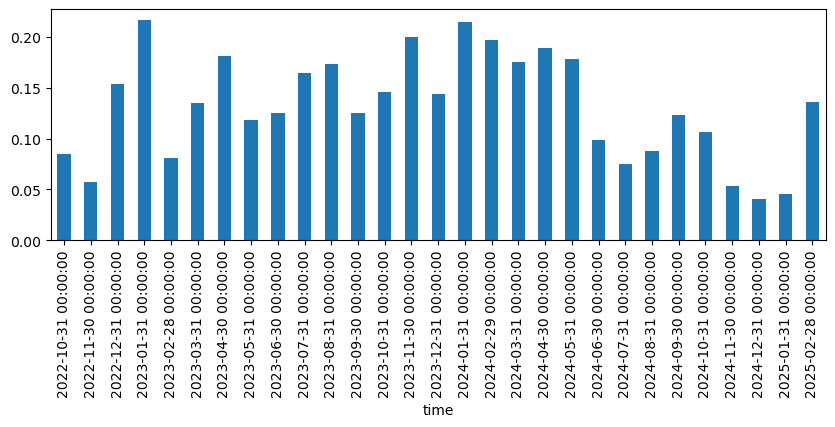

In [2869]:
mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            roc_auc_score(x['target'], x['y_pred'])
                                                                                                          ) - 0.5).plot.bar()

#### 2. WIN

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/3700073749.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


<Axes: xlabel='time'>

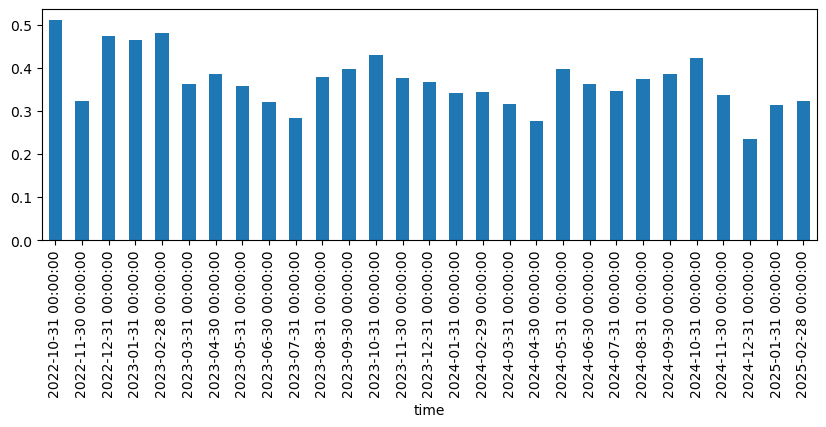

In [2875]:
q = 0.995
col_target = 'target'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()).plot.bar()

#### 3. income_rate

In [2879]:
#поточечный

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/2532690047.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:


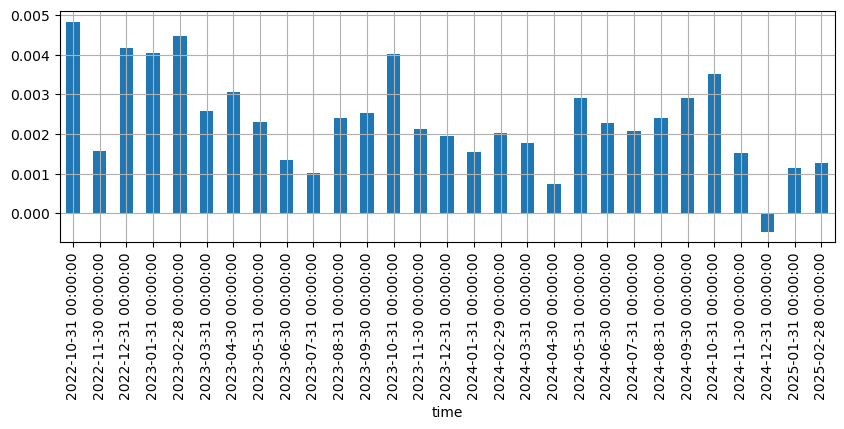

In [2881]:
q = 0.995
col_target = 'income_rate'

mask_last_bin = df['y_pred'] >= np.quantile(df.loc[mask_valid, 'y_pred'], q=q)

mask_data = df['y_pred'].notnull()
plt.figure(figsize=(10, 3))
(df.loc[mask_data&mask_last_bin, ['time', 'target', 'income_rate', 'y_pred']].groupby(pd.Grouper(key='time', freq='ME')).apply(lambda x:
                                                                            x[col_target].mean()) -1).plot.bar()
plt.grid()

#### 4. Отложенная выборка

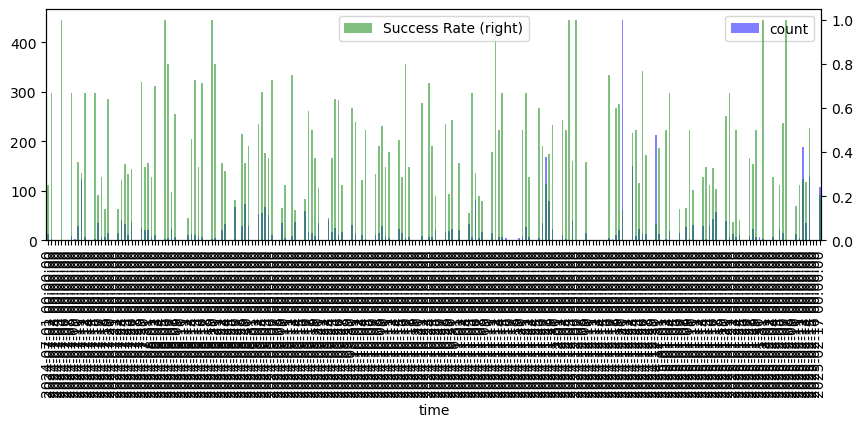

INCOME_RATE


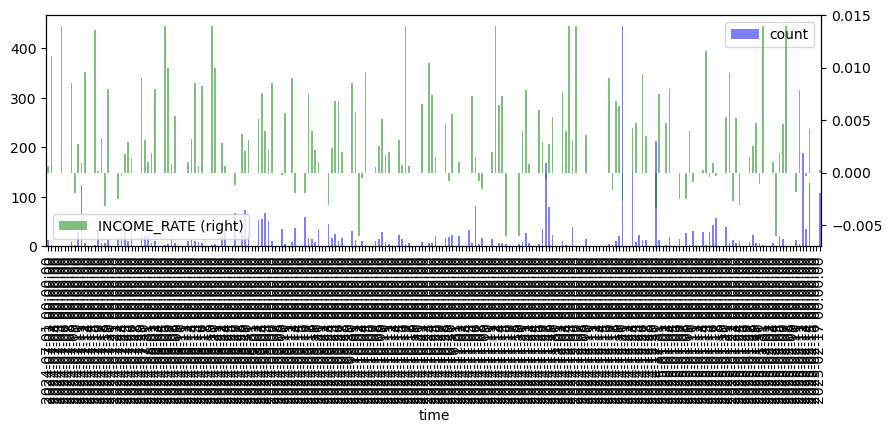

In [2888]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.995
freq='D'

mask_data = mask_valid|mask_test|mask_test2|mask_test3

threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [2891]:
#y_test3

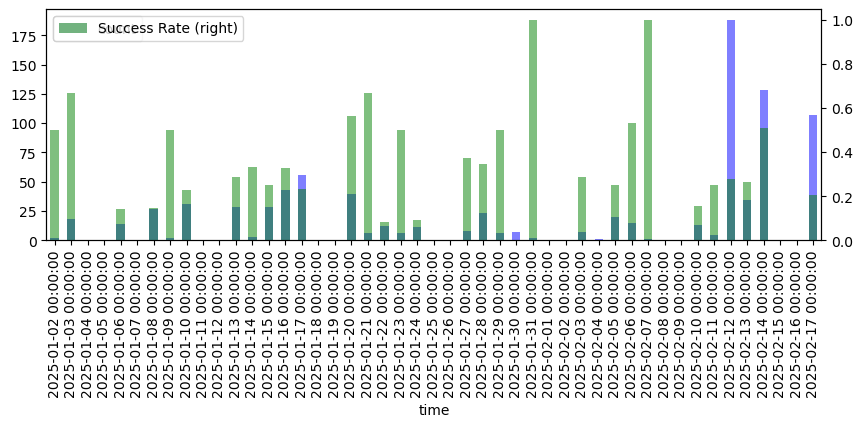

INCOME_RATE


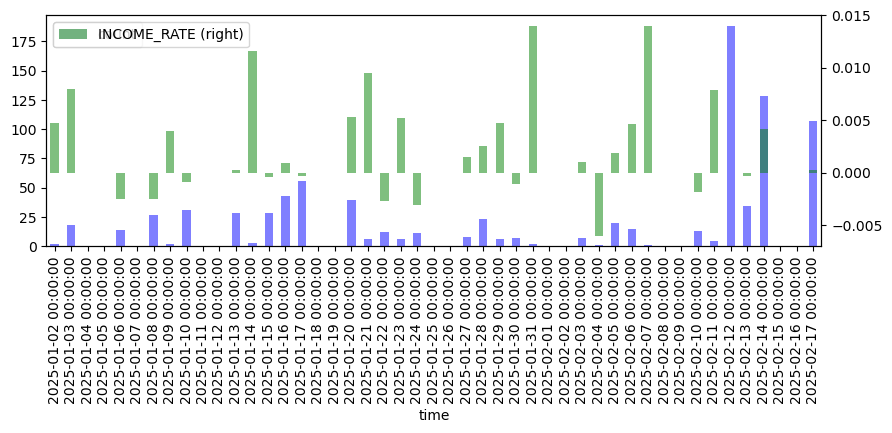

In [2893]:
#distibution in time
#win
col_pred = 'y_pred'
q = 0.995
freq='D'


mask_data = mask_test3


threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] >= threshold


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [2896]:
#mean_income_rate_by_day
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean(), (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()


(0.004514487, 0.0037571073, 0.0037957854)

In [2898]:
df.loc[mask_valid&mask_last_bin, 'time'].dt.date.nunique(), df.loc[mask_test&mask_last_bin, 'time'].dt.date.nunique(),  df.loc[mask_test2&mask_last_bin, 'time'].dt.date.nunique()


(40, 40, 38)

In [2900]:
threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=0.995)
threshold

0.3095578175723138

In [2902]:
#sum_income_rate
mean_income_rate_month(D_valid, y_pred_valid, threshold=threshold), mean_income_rate_month(D_test, y_pred_test, threshold=threshold), mean_income_rate_month(D_test2, y_pred_test2, threshold=threshold)

(0.08828330122762255, 0.07514214608818293, 0.07379712939782199)

In [2905]:
#test3
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).mean()

0.0026310887

In [2907]:
df.loc[mask_test3&mask_last_bin, 'time'].dt.date.nunique()

32

In [2909]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=threshold)

0.0561298926671346

In [2913]:
mask_data = mask_valid | mask_test | mask_test2

In [2915]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()


/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/1640586492.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_data&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003962059647349988

In [2918]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/1656526771.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_valid&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.003121483325958252

In [2920]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/192763211.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0038823381066322325

In [2922]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/1559495362.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test2&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0049307942390441895

In [2924]:
n = 0
pd.set_option('display.max_rows', 200)
(df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: x['income_rate'].values[n] if x.shape[0] > n else None) - 1).mean()

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/2683039865.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  (df.loc[mask_test3&mask_last_bin, ['time', 'income_rate', 'ticker']].groupby(pd.Grouper(key='time', freq='D')).apply(


0.0013105198740959167

#### Points in life

In [2928]:
threshold

0.3095578175723138

In [2930]:
mask_dev = df['time'] > pd.Timestamp('2025-01-20')
df.loc[mask_dev, 'y_pred'] = model.predict(df.loc[mask_dev, features_fe]) #feratures_fe

#threshold = 0.5695387939626755
df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(
    lambda x: (x['y_pred'] >= threshold).sum())

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_52331/1532415291.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_dev, ['time', 'y_pred']].groupby(pd.Grouper(key='time', freq='D')).apply(


time
2025-01-20     39
2025-01-21      6
2025-01-22     12
2025-01-23      6
2025-01-24     11
2025-01-25      0
2025-01-26      0
2025-01-27      8
2025-01-28     23
2025-01-29      6
2025-01-30      7
2025-01-31      2
2025-02-01      0
2025-02-02      0
2025-02-03      7
2025-02-04      1
2025-02-05     20
2025-02-06     15
2025-02-07      1
2025-02-08      0
2025-02-09      0
2025-02-10     13
2025-02-11      4
2025-02-12    188
2025-02-13     34
2025-02-14    128
2025-02-15      0
2025-02-16      0
2025-02-17    107
Freq: D, dtype: int64

### Обучить на всем

In [2938]:
features_fe

['close/close_w5_ma',
 'close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close_w5_min/close']

In [122]:
features_fe = ['close/close_w5_ma',
 'close/close_w10_ma',
 'close/close_w20_ma',
 'close/close_w5_expma',
 'close/close_w10_expma',
 'close_w5_min/close']

cat_features = []

In [124]:
mask_data = mask_train | mask_valid | mask_test | mask_test2
#mask_data = (pd.Timestamp('2024-01-01') <= df['time']) &  (df['time'] < pd.Timestamp('2025-01-01'))
#print(mask_data.sum())
#mask_data = mask_valid | mask_test | mask_test2

D_data = lgbm.Dataset(df.loc[mask_data, features_fe], label=df.loc[mask_data, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)


D_data.income_rate = df.loc[mask_data, 'income_rate'].values

D_data.time = df.loc[mask_data, 'time'].values

In [127]:
D_test3 = lgbm.Dataset(df.loc[mask_test3, features_fe], label=df.loc[mask_test3, target], feature_name=features_fe, categorical_feature=cat_features, free_raw_data=False)
D_test3.income_rate = df.loc[mask_test3, 'income_rate'].values
D_test3.time = df.loc[mask_test3, 'time'].values

In [129]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_boost_round':100,
 'num_leaves': 5,
 'feature_fraction': 0.5,
 'bagging_fraction': 0.5,
 'bagging_freq': 1,
 'lambda_l1': 100,
 'lambda_l2': 100}

In [131]:
#model.num_trees()

In [133]:
#del params['metric'], params['early_stopping']

In [135]:
#params['num_boost_round'] = 6

In [137]:
model = lgbm.train(params, train_set=D_data)
model.num_trees()

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 177704, number of negative: 1749246
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1926950, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092220 -> initscore=-2.286821
[LightGBM] [Info] Start training from score -2.286821


100

In [139]:
dump_pkl(model, 'model_+0.5_-1.5_4hour.pkl')

In [143]:
y_pred_data= model.predict(D_data.data)


df["y_pred"] = None
df.loc[mask_data, 'y_pred'] = y_pred_data

roc_auc_score(D_data.label, y_pred_data)

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_54181/1894950171.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["y_pred"] = None


0.648510091626979

In [145]:
y_pred_test3 = model.predict(D_test3.data)
df.loc[mask_test3, 'y_pred'] = y_pred_test3
roc_auc_score(D_test3.label, y_pred_test3)

0.5742336054300945

In [150]:
THRESHOLD = 0.3095578175723138
THRESHOLD

0.3095578175723138

In [152]:
mean_income_rate_point(D_data, y_pred_data, threshold=THRESHOLD)

0.0022851228713989258

In [154]:
mean_income_rate_day(D_data, y_pred_data, threshold=THRESHOLD)

0.0034902073

In [156]:
mean_income_rate_month(D_data, y_pred_data, threshold=THRESHOLD)

0.07233913765828076

In [159]:
mean_income_rate_point(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0010294914245605469

In [161]:
mean_income_rate_day(D_test3, y_pred_test3, threshold=THRESHOLD)

0.0026154406

In [163]:
mean_income_rate_month(D_test3, y_pred_test3, threshold=THRESHOLD)

0.05579606691996256

In [165]:
# Получше, однако

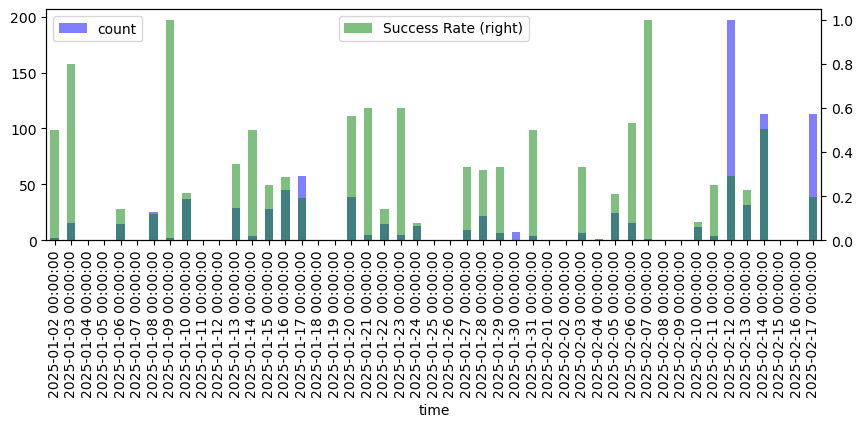

INCOME_RATE


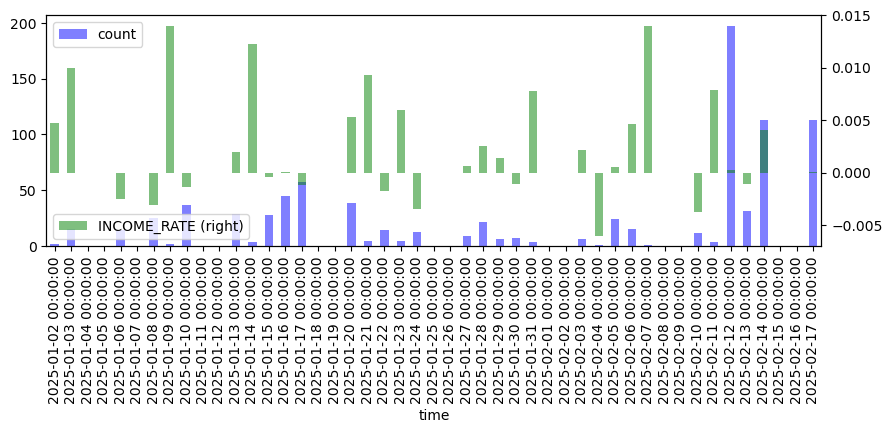

In [167]:
#distibution in time
#win
col_pred = 'y_pred'
freq='D'


mask_data = mask_test3


#threshold = np.quantile(df.loc[mask_valid, col_pred], q=q)
mask_last_bin = df[col_pred] > THRESHOLD


plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
df.loc[mask_data&mask_last_bin, ['time', 'target']].groupby(pd.Grouper(key='time', freq=freq)).target.mean().plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='Success Rate')
plt.legend()
plt.show()


#distibution in time
#income_rate
print('INCOME_RATE')

plt.figure(figsize=(10, 3))
df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.count().plot.bar(sharex=True, color='blue', alpha=0.5, label='count')
#plt.show()
plt.legend()
(df.loc[mask_data&mask_last_bin, ['time', 'income_rate']].groupby(pd.Grouper(key='time', freq=freq)).income_rate.mean() - 1).plot.bar(sharex=True, color='green', secondary_y=True, alpha=0.5, label='INCOME_RATE')
plt.legend()
plt.show()

In [170]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features_fe, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: x[1])

[('close/close_w5_expma', 5.83),
 ('close/close_w10_ma', 7.76),
 ('close/close_w10_expma', 11.1),
 ('close/close_w5_ma', 13.24),
 ('close/close_w20_ma', 25.44),
 ('close_w5_min/close', 36.64)]